In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error, mean_squared_error

## Defining constants

In [2]:
target = 'num_orders'

features = ['week', 'center_id', 'meal_id', 'base_price', 'discount', 'promotion', 'city_code', 'center_type', 
            'op_area', 'category', 'year']

encoded_columns = ['week_1', 'center_id_55', 'meal_id_1885', 'city_code_590', 'region_code_56', 'center_type_TYPE_A', 
                 'category_Beverages', 'cuisine_Thai', 'year_1', 'month_1', 'week_in_month_1']

categorical_columns = ['week', 'center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 'promotion', 
                       'city_code', 'region_code', 'center_type', 'category', 'cuisine', 'year', 'month', 
                       'week_in_month']

def evaluate(y_test, y_pred):
    return 100 * np.sqrt(mean_squared_error(y_test, y_pred))

# Reading Data

In [3]:
trainset = pd.read_csv("../data/train/train_feature.csv", index_col='id')
trainset.head()

,num_orders,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,discount,year,month,week_in_month
id,,,,,,,,,,,,,,,,,,
1379560,177,1,55,1885,136.83,152.29,0,0,647,56,TYPE_C,2.0,Beverages,Thai,15.46,1,1,1
1466964,270,1,55,1993,136.83,135.83,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,1,1,1
1346989,189,1,55,2539,134.86,135.86,0,0,647,56,TYPE_C,2.0,Beverages,Thai,1.00,1,1,1
1338232,54,1,55,2139,339.50,437.53,0,0,647,56,TYPE_C,2.0,Beverages,Indian,98.03,1,1,1
1448490,40,1,55,2631,243.50,242.50,0,0,647,56,TYPE_C,2.0,Beverages,Indian,-1.00,1,1,1


In [4]:
testset = pd.read_csv("../data/test/test_feature.csv", index_col='id')
testset.head()

,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,discount,year,month,week_in_month
id,,,,,,,,,,,,,,,,,
1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,1.0,3,11,2
1127204,146,55,1993,160.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.0,3,11,2
1212707,146,55,2539,157.14,159.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai,2.0,3,11,2
1082698,146,55,2631,162.02,162.02,0,0,647,56,TYPE_C,2.0,Beverages,Indian,0.0,3,11,2
1400926,146,55,1248,163.93,163.93,0,0,647,56,TYPE_C,2.0,Beverages,Indian,0.0,3,11,2


# Data Preprocessing

In [5]:
def preprocess(trainset, testset, remove_outliers=False):
    
    if remove_outliers:
        trainset = trainset[trainset.num_orders <= 20000]
        trainset = trainset[trainset.checkout_price >= 3]
        
    dataset = trainset.append(testset, sort=False).fillna(0)
    
    dataset['promotion'] = dataset['emailer_for_promotion'] + dataset['homepage_featured']
    for column in categorical_columns:
        dataset[column] = dataset[column].astype('category')
      
    dataset = dataset[features]
    
#     dataset = pd.get_dummies(dataset[features])
#     dataset = dataset.drop(encoded_columns, axis=1)
    
    trainset = trainset[[target]].join(dataset)
    testset = testset[[]].join(dataset)
    
    return trainset, testset

In [6]:
trainset, testset = preprocess(trainset, testset)

print("Trainset size: {}".format(trainset.shape))
print("Testset size: {}".format(testset.shape))

Trainset size: (456548, 12)
Testset size: (32573, 11)


#### Split the trainset into training and validation set

In [7]:
# feature_columns = trainset.columns
# feature_columns = feature_columns[feature_columns != target]
# feature_columns.shape

feature_columns = features

In [8]:
trainset, validationset = train_test_split(trainset, random_state=41, test_size=0.2)

X_train, y_train = trainset[feature_columns], np.log(trainset[target])
X_val, y_val = validationset[feature_columns], np.log(validationset[target])

print("Train set size: {}".format(X_train.shape))
print("Validation set size: {}".format(X_val.shape))

Train set size: (365238, 11)
Validation set size: (91310, 11)


# Training Models

### LightGBM

In [9]:
simple_gbm_model = LGBMRegressor(random_state=41)
simple_gbm_model.fit(X_train, y_train, eval_metric='rmse')
y_pred = simple_gbm_model.predict(X_val)

evaluate(y_val, y_pred)

50.145972953831496

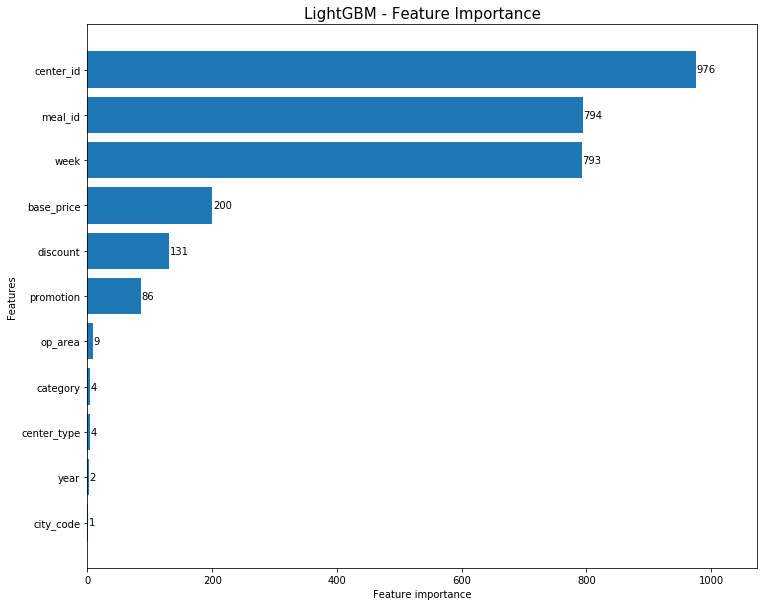

In [10]:
ax = plot_importance(simple_gbm_model, max_num_features=50, height=0.8, figsize=(12, 10))
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

# Submission

In [11]:
best_model_name = 'simple_gbm_model'
best_model = simple_gbm_model

In [12]:
X_test = testset[feature_columns]
y_pred = best_model.predict(X_test)
testset[target] = np.round(np.exp(y_pred), decimals=0)

submission = testset[[target]]
submission.to_csv('../data/submission/' + best_model_name + '.csv')

## Result

<p>Public score: <b>58.3298104848408</b></p>